In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

### data

In [2]:
X = pd.read_csv('mnist_data.csv').values[:, 1:]
y = pd.read_csv('mnist_target.csv').values[:, 1]
X = X / 255
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [3]:
def mini_batches(X, y, batch_size):
    m, _ = X.shape
    indices = list(range(m))
    X_, y_ = torch.Tensor(X).float(), torch.Tensor(y).long()
    X_, y_ = X_[indices], y_[indices]
    pos = 0
    while pos < m:
        X_batch, y_batch = X_[pos:pos+batch_size], y_[pos:pos+batch_size]
        yield (X_batch, y_batch)
        pos += batch_size

### model

In [46]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)
    
    def predict(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=1)

### model training

In [47]:
LR = 5e-3
MOMENTUM = 0.9
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
batch_size = 64

classifier = Classifier(input_size, hidden_sizes, output_size)
optimizer = optim.SGD(classifier.parameters(), lr=LR, momentum=MOMENTUM)
loss_function = nn.NLLLoss()

In [48]:
n_epochs = 30
losses = []

def train():
    for i in range(n_epochs):
        epoch_loss = 0
        for batch in mini_batches(X_train, y_train, 64):
            X_, y_ = batch
            y_hat = classifier(X_)
            optimizer.zero_grad()
            loss = loss_function(y_hat, y_)
            epoch_loss += loss
            loss.backward()
            optimizer.step()
        print(f'{i} epoch loss = {epoch_loss}')
        losses.append(epoch_loss)

In [49]:
train()

0 epoch loss = 665.2493896484375
1 epoch loss = 244.6355438232422
2 epoch loss = 188.49159240722656
3 epoch loss = 149.6293487548828
4 epoch loss = 122.643310546875
5 epoch loss = 103.14611053466797
6 epoch loss = 88.41453552246094
7 epoch loss = 77.00957489013672
8 epoch loss = 67.7902603149414
9 epoch loss = 60.29049301147461
10 epoch loss = 53.99812316894531
11 epoch loss = 48.5218391418457
12 epoch loss = 43.720619201660156
13 epoch loss = 39.46942901611328
14 epoch loss = 35.76572799682617
15 epoch loss = 32.342708587646484
16 epoch loss = 29.31370735168457
17 epoch loss = 26.538219451904297
18 epoch loss = 24.02279281616211
19 epoch loss = 21.75471305847168
20 epoch loss = 19.67836570739746
21 epoch loss = 17.76605987548828
22 epoch loss = 16.05597686767578
23 epoch loss = 14.533175468444824
24 epoch loss = 13.103070259094238
25 epoch loss = 11.854777336120605
26 epoch loss = 10.735057830810547
27 epoch loss = 9.701872825622559
28 epoch loss = 8.821523666381836
29 epoch loss = 8.

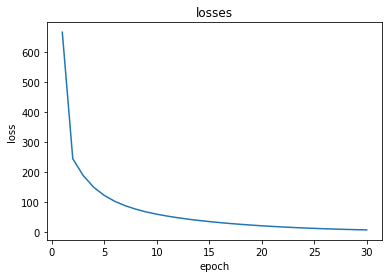

In [50]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, n_epochs+1), losses)
plt.title('losses')
plt.xlabel('epoch', fontsize=10)
plt.ylabel('loss', fontsize=10)
plt.show()

## adversarial attack

In [51]:
def fast_adversarial_example(dig, n=784, n_classes=10, eta=0.01, iters=10):
    y = torch.tensor([dig]).long()
    x = Variable(torch.tensor(np.random.normal(loc=0, scale=0.01, size=(1,n))).float(), requires_grad=True)
    for _ in range(iters):
        y_hat = classifier(x)
        classifier.zero_grad()
        loss = loss_function(y_hat, y)
        loss.backward()
        grad = x.grad.data
        x = Variable(torch.clamp(x - eta * grad.sign(), 0, 1), requires_grad=True)
    return x

In [89]:
def predict(x):
    y_hat = classifier.predict(x)
    return torch.argmax(y_hat), y_hat

In [99]:
example = fast_adversarial_example(8, eta=0.1, iters=10)
alpha = 0.5
X_spoiled = np.maximum(X_test*(1-alpha), alpha*example.detach().numpy())
x_target = torch.tensor(X_spoiled[0]).float()
y_pred, score = predict(x_target.unsqueeze(0))
x = np.arange(10)
score = list(score.data.numpy().reshape(-1))

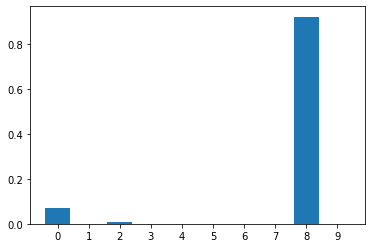

In [100]:
x = np.arange(10)
plt.bar(x, score)
plt.xticks(x)
plt.show()